# llama3 implemented from scratch
<!-- in this file, i implemented llama3 from scratch, one tensor and matrix multiplication at a time. -->
在这个文件中, 我从零实现了 llama3, 每次实现一个张量和矩阵乘法。

<!-- also, im going to load tensors directly from the model file that meta provided for llama3, you need to download the weights before running this file.
here is the offical link to download the weights: https://llama.meta.com/llama-downloads/ -->
另外, 我将直接(从 meta 为 llama3 提供的模型文件中)加载张量, 您需要在运行此文件前下载权重。下载权重的非官方链接: https://huggingface.co/bofenghuang/Meta-Llama-3-8B/tree/cd892e8f4da1043d4b01d5ea182a2e8412bf658f/original

<div>
    <img src="images/archi.png"/>
</div>

## tokenizer
<!-- im not going to implement a bpe tokenizer (but andrej karpathy has a really clean implementation) -->
我不会实现 <font color="red">**bpe 分词器**</font> (但 andrej karpathy 有一个非常干净的实现)

<!-- link to his implementation: https://github.com/karpathy/minbpe -->
他的实现链接: https://github.com/karpathy/minbpe

<div>
    <img src="images/karpathyminbpe.png" width="600"/>
</div>

In [ ]:
!conda install tiktoken -c conda-forge
!conda install blobfile -c conda-forge

In [ ]:
"""
%cd /mnt/d/github
!git clone git@github.com:cfzngcfz/llama3-from-scratch.git
%cd llama3-from-scratch
!mkdir Meta-Llama-3-8B
%cd Llama-3-8B
!wget https://huggingface.co/bofenghuang/Meta-Llama-3-8B/blob/cd892e8f4da1043d4b01d5ea182a2e8412bf658f/original/params.json
!wget https://huggingface.co/bofenghuang/Meta-Llama-3-8B/blob/cd892e8f4da1043d4b01d5ea182a2e8412bf658f/original/tokenizer.model
!wget https://huggingface.co/bofenghuang/Meta-Llama-3-8B/blob/cd892e8f4da1043d4b01d5ea182a2e8412bf658f/original/consolidated.00.pth
!mv original_params.json params.json
"""

In [1]:
%cd /mnt/d/github
%cd llama3-from-scratch

/mnt/d/github
/mnt/d/github/llama3-from-scratch


In [2]:
from pathlib import Path
import tiktoken
from tiktoken.load import load_tiktoken_bpe
import torch
import json
import matplotlib.pyplot as plt

tokenizer_path = "Meta-Llama-3-8B/tokenizer.model"
special_tokens = [
            "<|begin_of_text|>",
            "<|end_of_text|>",
            "<|reserved_special_token_0|>",
            "<|reserved_special_token_1|>",
            "<|reserved_special_token_2|>",
            "<|reserved_special_token_3|>",
            "<|start_header_id|>",
            "<|end_header_id|>",
            "<|reserved_special_token_4|>",
            "<|eot_id|>",  # end of turn
        ] + [f"<|reserved_special_token_{i}|>" for i in range(5, 256 - 5)]
mergeable_ranks = load_tiktoken_bpe(tokenizer_path)
tokenizer = tiktoken.Encoding(
    name=Path(tokenizer_path).name,
    pat_str=r"(?i:'s|'t|'re|'ve|'m|'ll|'d)|[^\r\n\p{L}\p{N}]?\p{L}+|\p{N}{1,3}| ?[^\s\p{L}\p{N}]+[\r\n]*|\s*[\r\n]+|\s+(?!\S)|\s+",
    mergeable_ranks=mergeable_ranks,
    special_tokens={token: len(mergeable_ranks) + i for i, token in enumerate(special_tokens)},
)

token_idx = tokenizer.encode("hello world!")
print("token indices of 'hello world!' are ", token_idx)
tokenizer.decode(token_idx)

token indices of 'hello world!' are  [15339, 1917, 0]


'hello world!'

In [3]:
# 词汇表中从 127985 到 128000 (不包含)的词元索引及其对应的词元
print("token index : token")
for token_idx in range(127985, 128000):
    print(token_idx, ":", tokenizer.decode([token_idx]))

token index : token
127985 :  густ
127986 :  Ваш
127987 :  امتی
127988 :  paramet
127989 :  Πανεπ
127990 : ์กร
127991 : ζα
127992 :  더욱
127993 : ولات
127994 : ватися
127995 :  kök
127996 : نب
127997 :  высокой
127998 : ーー
127999 : 锦


In [4]:
# 词汇表中从 128000 到 128012 (不包含)的词元索引(即前 12 个特殊词元)及其对应的词元
print("token index : token")
for token_idx in range(128000, 128012):
    print(token_idx, ":", tokenizer.decode([token_idx]))

token index : token
128000 : <|begin_of_text|>
128001 : <|end_of_text|>
128002 : <|reserved_special_token_0|>
128003 : <|reserved_special_token_1|>
128004 : <|reserved_special_token_2|>
128005 : <|reserved_special_token_3|>
128006 : <|start_header_id|>
128007 : <|end_header_id|>
128008 : <|reserved_special_token_4|>
128009 : <|eot_id|>
128010 : <|reserved_special_token_5|>
128011 : <|reserved_special_token_6|>


In [5]:
# 词汇表中从 128246 到 128256 (不包含)的词元索引(即最后 10 个特殊词元)及其对应的词元
print("token index : token")
for token_idx in range(128246, 128256):
    print(token_idx, ":", tokenizer.decode([token_idx]))

token index : token
128246 : <|reserved_special_token_241|>
128247 : <|reserved_special_token_242|>
128248 : <|reserved_special_token_243|>
128249 : <|reserved_special_token_244|>
128250 : <|reserved_special_token_245|>
128251 : <|reserved_special_token_246|>
128252 : <|reserved_special_token_247|>
128253 : <|reserved_special_token_248|>
128254 : <|reserved_special_token_249|>
128255 : <|reserved_special_token_250|>


## 读取模型权重
<!-- normally, reading this depends on how the model classes are written and the variable names inside them. -->
通常, 读取它取决于模型类的编写方式, 以及其中的变量名称。

<!-- but since we are implementing llama3 from scratch we will read the file one tensor at a time. -->
但由于我们从零实现 llama3, 我们将一次从文件中读取一个张量。
<div>
    <img src="images/model.png" width="600"/>
</div>

In [6]:
model = torch.load("Meta-Llama-3-8B/consolidated.00.pth") # 这里的 model 是模型权重

In [7]:
# print(json.dumps(list(model.keys())[:20], indent=4))
list(model.keys())[:10] + ["..."] + list(model.keys())[-11:] 

['tok_embeddings.weight',
 'layers.0.attention.wq.weight',
 'layers.0.attention.wk.weight',
 'layers.0.attention.wv.weight',
 'layers.0.attention.wo.weight',
 'layers.0.feed_forward.w1.weight',
 'layers.0.feed_forward.w3.weight',
 'layers.0.feed_forward.w2.weight',
 'layers.0.attention_norm.weight',
 'layers.0.ffn_norm.weight',
 '...',
 'layers.31.attention.wq.weight',
 'layers.31.attention.wk.weight',
 'layers.31.attention.wv.weight',
 'layers.31.attention.wo.weight',
 'layers.31.feed_forward.w1.weight',
 'layers.31.feed_forward.w3.weight',
 'layers.31.feed_forward.w2.weight',
 'layers.31.attention_norm.weight',
 'layers.31.ffn_norm.weight',
 'norm.weight',
 'output.weight']

## 读取 config, 获取有关模型的详细信息
<!-- 1. the model has 32 transformer layers
2. each multi-head attention block has 32 heads
3. the vocab size and so on -->

1. 该模型有 32 个 transformer层
2. 每个多头注意力模块有 32 个头
3. 词汇大小等等

In [8]:
with open("Meta-Llama-3-8B/params.json", "r") as f:
    config = json.load(f)
config

{'dim': 4096,
 'n_layers': 32,
 'n_heads': 32,
 'n_kv_heads': 8,
 'vocab_size': 128256,
 'multiple_of': 1024,
 'ffn_dim_multiplier': 1.3,
 'norm_eps': 1e-05,
 'rope_theta': 500000.0}

In [9]:
dim = config["dim"]
n_layers = config["n_layers"]
n_heads = config["n_heads"]
n_kv_heads = config["n_kv_heads"]
vocab_size = config["vocab_size"]
multiple_of = config["multiple_of"]
ffn_dim_multiplier = config["ffn_dim_multiplier"]
norm_eps = config["norm_eps"]
rope_theta = torch.tensor(config["rope_theta"])

## 将 text 转换为 tokens
<!-- here we use tiktoken (i think an openai library) as the tokenizer -->
这里我们使用 tiktoken (作者认为是一个 openai 库) 作为 tokenizer
<div>
    <img src="images/tokens.png" width="600"/>
</div>

In [10]:
prompt = "the answer to the ultimate question of life, the universe, and everything is "
tokens = [128000] + tokenizer.encode(prompt)
# print(tokens)
print("length of tokens =", len(tokens))
tokens = torch.tensor(tokens)
prompt_split_as_tokens = [tokenizer.decode([token.item()]) for token in tokens]
# print(prompt_split_as_tokens)
for token, token_idx in zip(prompt_split_as_tokens, tokens):
    print("'" + token + "'" , ":", token_idx.item())

length of tokens = 17
'<|begin_of_text|>' : 128000
'the' : 1820
' answer' : 4320
' to' : 311
' the' : 279
' ultimate' : 17139
' question' : 3488
' of' : 315
' life' : 2324
',' : 11
' the' : 279
' universe' : 15861
',' : 11
' and' : 323
' everything' : 4395
' is' : 374
' ' : 220


<!-- ## converting tokens to their embedding
IM SORRY but this is the only part of the codebase where i use an inbuilt neural network module
<br>
anyway, so our [17x1] tokens are now [17x4096], i.e. 17 embeddings (one for each token) of length 4096
<br>
<br>
note: keep track of the shapes, it makes it much easier to understand everything -->
## 将tokens转换为embedding
这是代码库中作者使用内置神经网络模块的唯一部分

<font color="red">[17x1] tokens 变成 [17x4096], 即 17 个嵌入(每个词元一个), 长度为 40969</font>
 
注意: 追踪形状, 这样更容易理解所有内容
<div>
    <img src="images/embeddings.png" width="600"/>
</div>

In [11]:
embedding_layer = torch.nn.Embedding(vocab_size, dim)
embedding_layer.weight.data.copy_(model["tok_embeddings.weight"])
token_embeddings_unnormalized = embedding_layer(tokens).to(torch.bfloat16)
print("weight of embedding_layer:\n\tshape =", embedding_layer.weight.shape, ", type is", embedding_layer.weight.dtype)
print("input of embedding_layer, i.e., token indices:\n\tshape =", tokens.shape, ", type is", tokens.dtype)
print("output of embedding_layer, i.e.,  unnormalized token embedding:\n\tshape =", token_embeddings_unnormalized.shape, ", type is", token_embeddings_unnormalized.dtype)

weight of embedding_layer:
	shape = torch.Size([128256, 4096]) , type is torch.float32
input of embedding_layer, i.e., token indices:
	shape = torch.Size([17]) , type is torch.int64
output of embedding_layer, i.e.,  unnormalized token embedding:
	shape = torch.Size([17, 4096]) , type is torch.bfloat16


<!-- ## we then normalize the embedding using rms normalization
please, note after this step the shapes dont change, the values are just normalized
<br>
things to keep in mind, we need a norm_eps (from config) because we dont want to accidently set rms to 0 and divide by 0
<br>
here is the formula: -->
## 构建 transformer 的第一层

### 使用 rms 归一化, 对嵌入进行归一化
请注意, 此步骤后, 形状不会改变, 值仅被归一化

需要注意的事情, 我们<font color="red">需要一个 **norm_eps** (来自 config), 因为我们不想不小心将 rms 设置为 0, 并除以 0 </font>

公式如下:
<div>
    <img src="images/rms.png" width="600"/>
</div>

In [12]:
# def rms_norm(tensor, norm_weights):
#     rms = (tensor.pow(2).mean(-1, keepdim=True) + norm_eps)**0.5
#     return tensor * (norm_weights / rms)
def rms_norm(tensor, norm_weights):
    # tensor is a_i, norm_weights is g_i
    return (tensor * torch.rsqrt(tensor.pow(2).mean(-1, keepdim=True) + norm_eps)) * norm_weights

<!-- # building the first first layer of the transformer

### normalization
you will see me accessing layer.0 from the model dict (this is the first layer)
<br>
anyway, so after normalizing our shapes are still [17x4096] same as embedding but normalized -->

### 归一化
您将看到我从模型字典访问 layer.0 (这是第一层)

在归一化之后, 我们的形状仍然是 [17x4096] 与嵌入相同, 但经过归一化

<div>
    <img src="images/norm.png" width="600"/>
</div>

In [13]:
token_embeddings = rms_norm(token_embeddings_unnormalized, model["layers.0.attention_norm.weight"])
print("a_i shape =", token_embeddings_unnormalized.shape, ", dtype =", token_embeddings_unnormalized.dtype)
print("g_i shape =", model["layers.0.attention_norm.weight"].shape, ", dtype =", model["layers.0.attention_norm.weight"].dtype)
print("\\bar{a_i} shape =", token_embeddings.shape, ", dtype =", token_embeddings.dtype)

a_i shape = torch.Size([17, 4096]) , dtype = torch.bfloat16
g_i shape = torch.Size([4096]) , dtype = torch.bfloat16
\bar{a_i} shape = torch.Size([17, 4096]) , dtype = torch.bfloat16


<!-- ### attention implemented from scratch
let's load the attention heads of the first layer of the transformer -->
### 从零实现的 attention
让我们加载 transformer 第一层的 attention heads
<div>
    <img src="images/qkv.png" width="600"/>
</div>

<br>

<!-- &gt; when we load the query, key, value and output vectors from the model we notice the shapes to be [4096x4096], [1024x4096], [1024x4096], [4096x4096]
<br>
&gt; at first glance this is weird because ideally we want each q,k,v and o for each head individually
<br>
&gt; the authors of the code bundled them togeather because its easy it helps parallize attention head multiplication.
<br>
&gt; im going to unwrap everything...  -->

* 当我们从模型中加载查询、键、值和输出向量时, 我们注意到形状为 [4096x4096]、[1024x4096]、[1024x4096]、[4096x4096]  
* 乍一看这很奇怪, 因为理想情况下我们希望每个头的每个 q、k、v 和 o 都独立 
* 代码的作者将它们捆绑在一起, 因为这<font color="red">**有助于并行计算注意力头乘法**</font>

In [14]:
print(
    model["layers.0.attention.wq.weight"].shape,
    model["layers.0.attention.wk.weight"].shape,
    model["layers.0.attention.wv.weight"].shape,
    model["layers.0.attention.wo.weight"].shape
)

torch.Size([4096, 4096]) torch.Size([1024, 4096]) torch.Size([1024, 4096]) torch.Size([4096, 4096])


<!-- ### unwrapping query
in the next section we will unwrap the queries from multiple attention heads, the resulting shape is [32x128x4096]
<br><br>
here, 32 is the number of attention heads in llama3, 128 is the size of the query vector and 4096 is the size of the token embedding -->
### 解密 query
我们将从多个 attention heads 中解密 queries, 结果形状为 [32x128x4096]

其中, 32 是 llama3 中 attention heads 的数量, 128 是 query 向量的长度, 4096 是 token 嵌入的大小

In [15]:
q_layer0 = model["layers.0.attention.wq.weight"]
head_dim = q_layer0.shape[0] // n_heads
q_layer0 = q_layer0.view(n_heads, head_dim, dim)
q_layer0.shape, q_layer0.dtype

(torch.Size([32, 128, 4096]), torch.bfloat16)

<!-- ### im going to implement the first head of the first layer
here i access the query weight matrix first head of the first layer, the size of this query weight matrix is [128x4096] -->
### 实现第一层的第一个头
这里我访问第一层第一个头的 query weight 矩阵, 该 query weight 矩阵的大小是 [128x4096]

In [16]:
q_layer0_head0 = q_layer0[0]
q_layer0_head0.shape

torch.Size([128, 4096])

<!-- ### we now multiply the query weights with the token embedding, to recive a query for the token
here you can see the resulting shape is [17x128], this is because we have 17 tokens and for each token there is a 128 length query. -->
### 现在将 query weights 与 token embedding 相乘, 以接收 token 的一个 query
在这里你可以看到结果形状是 [17x128], 这是因为我们有 17 个 tokens, 对于每个 token, 都有一个长度为 128 度的 query。
<div>
    <img src="images/q_per_token.png" width="600"/>
</div>

In [17]:
q_per_token = torch.matmul(token_embeddings, q_layer0_head0.T)
print("token_embeddings shape =", token_embeddings.shape, ", dtype =", token_embeddings.dtype)
print("q_layer0_head0 shape =", q_layer0_head0.shape, ", dtype =", q_layer0_head0.dtype)
print("q_per_token shape =", q_per_token.shape, ", dtype =", q_per_token.dtype)

token_embeddings shape = torch.Size([17, 4096]) , dtype = torch.bfloat16
q_layer0_head0 shape = torch.Size([128, 4096]) , dtype = torch.bfloat16
q_per_token shape = torch.Size([17, 128]) , dtype = torch.bfloat16


**todo**: 如下理解是否正确?
- 一个 head 包含一个 query, 一个 key, 和 一个 value
- 一个 query 的大小为[17 * 128], 即 q_per_token
- 其中每行对应一个 token, 成为 query vector, 
- 该 query 的权重大小为 [128 * 4096], 即 q_layer0_head0

<!-- ## positioning encoding
we are now at a stage where we have a query vector for each token in our prompt, but if you think about it -- the indivitually query vector has no idea about the position in the prompt.
<br><br>
query: "the answer to the ultimate question of life, the universe, and everything is "
<br><br>
in our prompt we have used "the" three times, we need the query vectors of all 3 "the" tokens to have different query vectors (each of size [1x128]) based on their positions in the query. we perform these rotations using RoPE (rotory positional embedding).
<br><br>  -->
<!-- ### RoPE
watch this video (this is what i watched) to understand the math.
https://www.youtube.com/watch?v=o29P0Kpobz0&t=530s -->

### 位置编码

我们现在处于一个阶段, 其中对于 prompt 中的每个 token, 都有一个 query 向量, 但是如果你仔细想想——单个 query 向量并不知道其在 prompt 中的位置。

query: "the answer to the ultimate question of life, the universe, and everything is "

在我们的 prompt 中, 我们使用了三次"the", 我们需要所有 3 个"the" tokens 的 query 向量根据它们在 query 中的位置具有不同的 query 向量(每个大小为 [1x128])。我们使用 RoPE (旋转位置嵌入) 执行这些旋转。

#### RoPE
观看此视频 (这是作者观看的) 以了解其数学。https://www.youtube.com/watch?v=o29P0Kpobz0&t=530s

<div>
    <img src="images/rope.png" width="600"/>
</div>

In [18]:
q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
print("q_per_token shape =", q_per_token.shape, ", dtype =", q_per_token.dtype)
print("q_per_token_split_into_pairs shape =", q_per_token_split_into_pairs.shape, ", dtype =", q_per_token_split_into_pairs.dtype)

q_per_token shape = torch.Size([17, 128]) , dtype = torch.bfloat16
q_per_token_split_into_pairs shape = torch.Size([17, 64, 2]) , dtype = torch.float32


<!-- in the above step, we split the query vectors into pairs, we apply a rotational angle shift to each pair!
<br><br>
we now have a vector of size [17x64x2], this is the 128 length queries split into 64 pairs for each token in the prompt! each of those 64 pairs will be rotated by m*(theta) where m is the position of the token for which we are rotating the query! -->

在上一步中, 我们将查询向量分成若干对, 并对每对应用旋转角度移位!

我们现在有一个大小为 [17x64x2] 的向量, 这是对 prompt 中的每个 token, 将长度为 128 的查询拆分为 64 个对! 这 64 对中的每一对都将旋转 $m * (\theta)$, 其中 $m$ 是我们要旋转查询的词元位置!

<div>
    <img src="images/qsplit.png" width="600"/>
</div>

<!-- ## using dot product of complex numbers to rotate a vector -->
### 使用复数的点积来旋转向量
<div>
    <img src="images/freq_cis.png" width="600"/>
</div>

In [19]:
zero_to_one_split_into_64_parts = torch.tensor(range(64))/64
zero_to_one_split_into_64_parts

tensor([0.0000, 0.0156, 0.0312, 0.0469, 0.0625, 0.0781, 0.0938, 0.1094, 0.1250,
        0.1406, 0.1562, 0.1719, 0.1875, 0.2031, 0.2188, 0.2344, 0.2500, 0.2656,
        0.2812, 0.2969, 0.3125, 0.3281, 0.3438, 0.3594, 0.3750, 0.3906, 0.4062,
        0.4219, 0.4375, 0.4531, 0.4688, 0.4844, 0.5000, 0.5156, 0.5312, 0.5469,
        0.5625, 0.5781, 0.5938, 0.6094, 0.6250, 0.6406, 0.6562, 0.6719, 0.6875,
        0.7031, 0.7188, 0.7344, 0.7500, 0.7656, 0.7812, 0.7969, 0.8125, 0.8281,
        0.8438, 0.8594, 0.8750, 0.8906, 0.9062, 0.9219, 0.9375, 0.9531, 0.9688,
        0.9844])

In [20]:
freqs = 1.0 / (rope_theta ** zero_to_one_split_into_64_parts) # rope_theta 来自 config
freqs

tensor([1.0000e+00, 8.1462e-01, 6.6360e-01, 5.4058e-01, 4.4037e-01, 3.5873e-01,
        2.9223e-01, 2.3805e-01, 1.9392e-01, 1.5797e-01, 1.2869e-01, 1.0483e-01,
        8.5397e-02, 6.9566e-02, 5.6670e-02, 4.6164e-02, 3.7606e-02, 3.0635e-02,
        2.4955e-02, 2.0329e-02, 1.6560e-02, 1.3490e-02, 1.0990e-02, 8.9523e-03,
        7.2927e-03, 5.9407e-03, 4.8394e-03, 3.9423e-03, 3.2114e-03, 2.6161e-03,
        2.1311e-03, 1.7360e-03, 1.4142e-03, 1.1520e-03, 9.3847e-04, 7.6450e-04,
        6.2277e-04, 5.0732e-04, 4.1327e-04, 3.3666e-04, 2.7425e-04, 2.2341e-04,
        1.8199e-04, 1.4825e-04, 1.2077e-04, 9.8381e-05, 8.0143e-05, 6.5286e-05,
        5.3183e-05, 4.3324e-05, 3.5292e-05, 2.8750e-05, 2.3420e-05, 1.9078e-05,
        1.5542e-05, 1.2660e-05, 1.0313e-05, 8.4015e-06, 6.8440e-06, 5.5752e-06,
        4.5417e-06, 3.6997e-06, 3.0139e-06, 2.4551e-06])

In [21]:
freqs_for_each_token = torch.outer(torch.arange(17), freqs) # 向量外积
print("freqs_for_each_token shape =", freqs_for_each_token.shape, ", dtype =", freqs_for_each_token.dtype)

# 生成复数的极坐标表示, 它接受两个参数: 模(radius)和角度(angle), 并返回对应的复数
freqs_cis = torch.polar(torch.ones_like(freqs_for_each_token), freqs_for_each_token) 
print("freqs_cis shape =", freqs_cis.shape, ", dtype =", freqs_cis.dtype)

freqs_for_each_token shape = torch.Size([17, 64]) , dtype = torch.float32
freqs_cis shape = torch.Size([17, 64]) , dtype = torch.complex64


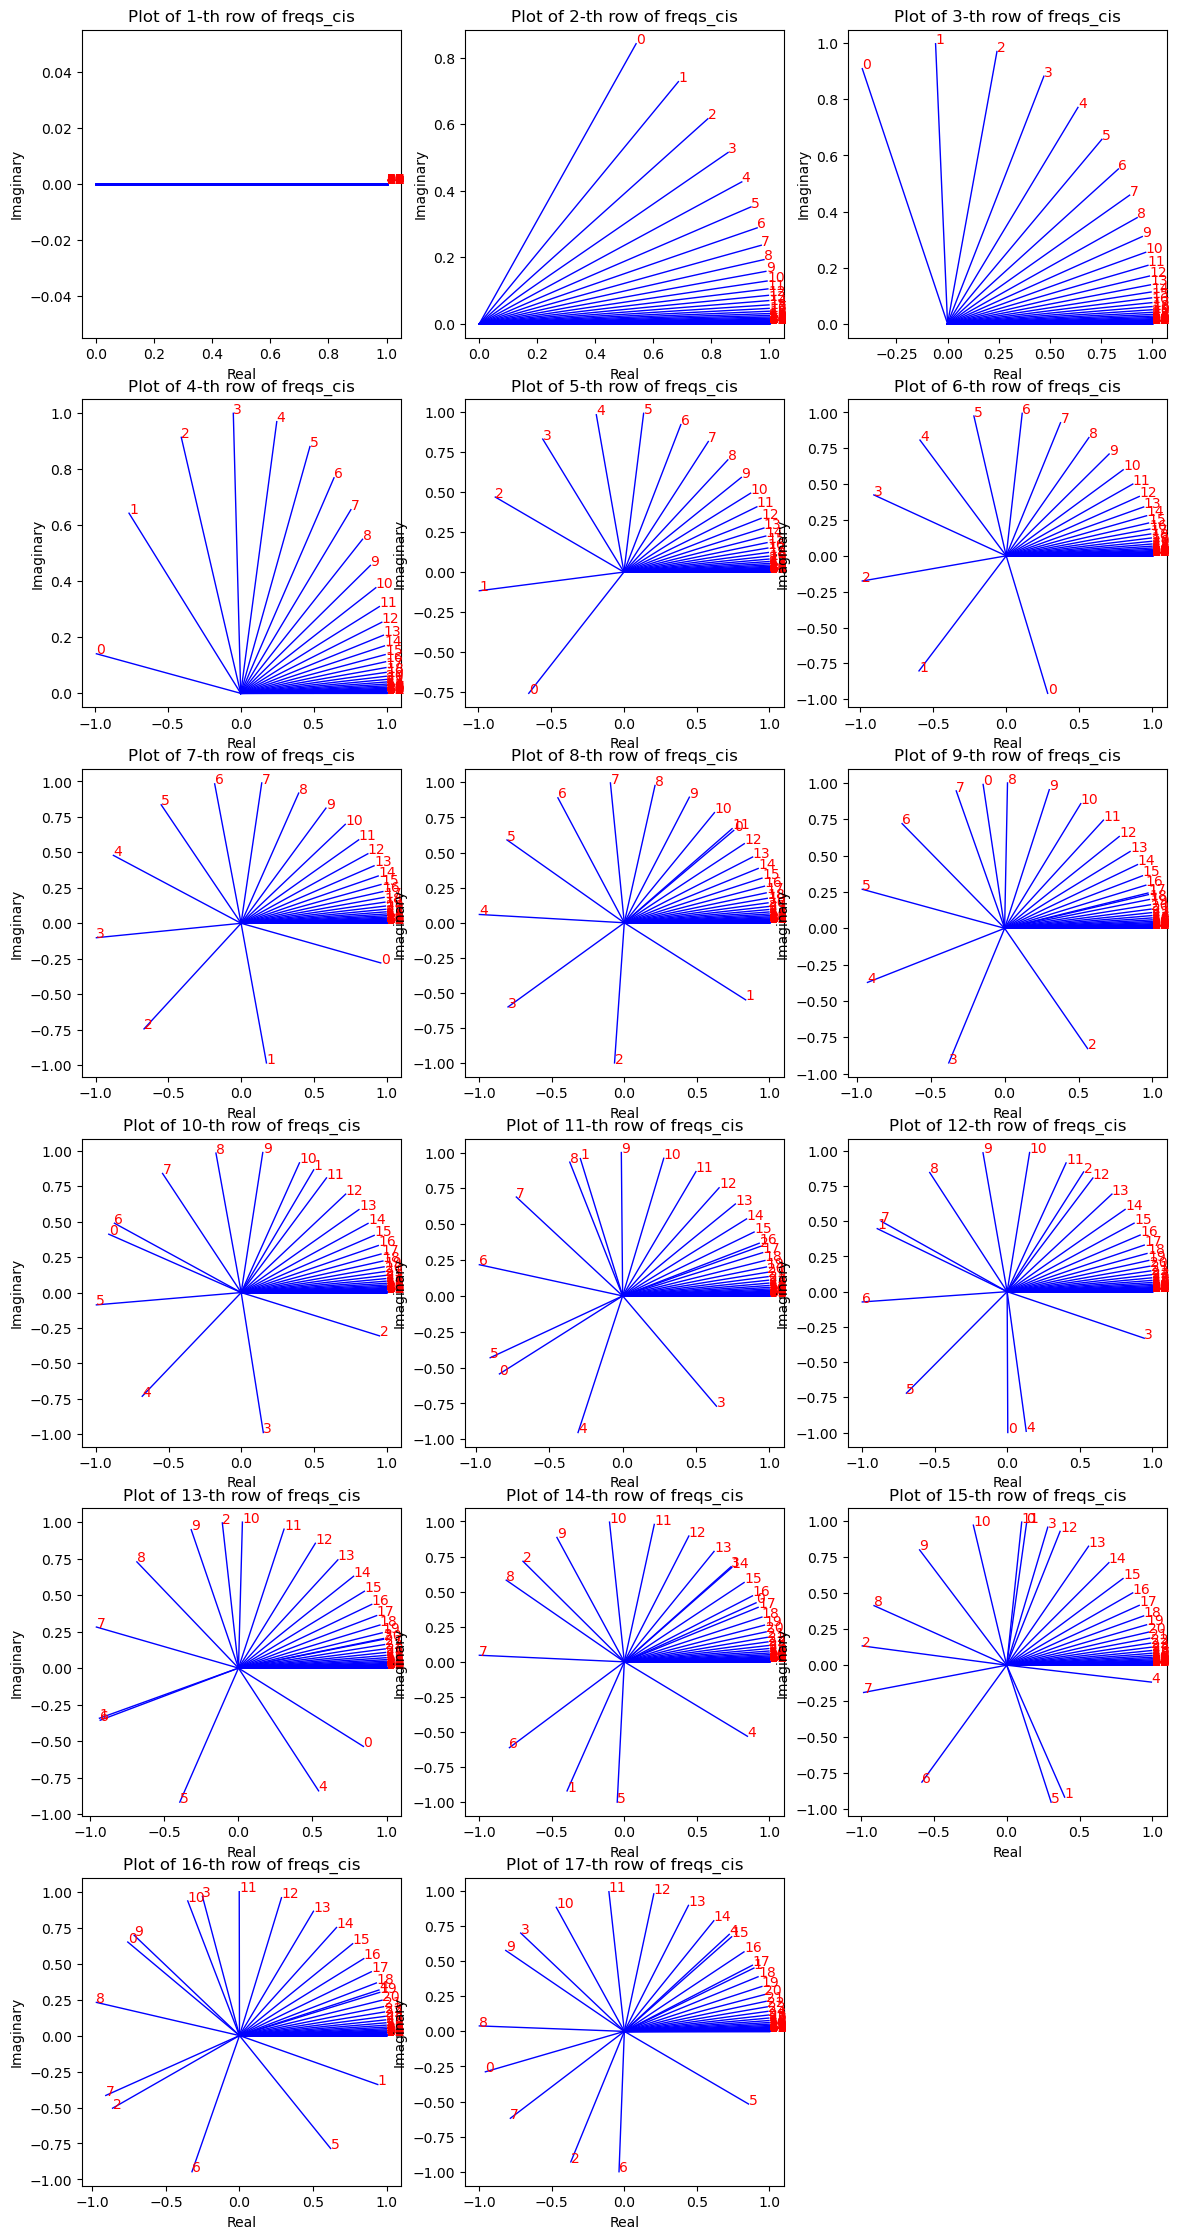

In [22]:
fig = plt.figure(figsize=(14, 28))
for row_idx in range(freqs_cis.shape[0]):
    value = freqs_cis[row_idx]
    ax = fig.add_subplot(6, 3, row_idx + 1)
    for i, element in enumerate(value):
        ax.plot([0, element.real], [0, element.imag], color='blue', linewidth=1, label=f"Index: {i}")
        ax.annotate(f"{i}", xy=(element.real, element.imag), color='red')
    ax.set_xlabel('Real')
    ax.set_ylabel('Imaginary')
    ax.set_title("Plot of " + str(row_idx + 1) + "-th row of freqs_cis")
# plt.show()

<!-- ### now that we have a complex number (the angle change vector) for every token's query element
we can convert our queries (the one we split into pairs) as complex numbers and then dot product to rotate the query based on the position
<br>
honeslty this is beautiful to think about :) -->
#### 现在我们为每个 token 的查询元素都得到了一个复数 (角度变化向量, 即 freqs_cis)
我们可以将查询 (我们其分成对) 转换为复数, 然后基于位置通过点积旋转查询

In [23]:
q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)
print("q_per_token_as_complex_numbers shape =", q_per_token_as_complex_numbers.shape, ", dtype =", q_per_token_as_complex_numbers.dtype)

q_per_token_as_complex_numbers shape = torch.Size([17, 64]) , dtype = torch.complex64


In [24]:
q_per_token_as_complex_numbers_rotated = q_per_token_as_complex_numbers * freqs_cis
print("freqs_cis shape =", freqs_cis.shape, ", dtype =", freqs_cis.dtype)
print("q_per_token_as_complex_numbers_rotated shape =", q_per_token_as_complex_numbers_rotated.shape, ", dtype =", q_per_token_as_complex_numbers_rotated.dtype)

freqs_cis shape = torch.Size([17, 64]) , dtype = torch.complex64
q_per_token_as_complex_numbers_rotated shape = torch.Size([17, 64]) , dtype = torch.complex64


<!-- ### after rotated vector is obtained
we can get back our the queries as pairs by viewing the complex numbers as real numbers again -->
#### 获得旋转向量后
我们可以通过将复数再次视为实数, 以成对的形式返回 queries

In [25]:
q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers_rotated)
q_per_token_split_into_pairs_rotated.shape, q_per_token_split_into_pairs_rotated.dtype

(torch.Size([17, 64, 2]), torch.float32)

<!-- the rotated pairs are now merged, we now have a new query vector (rotated query vector) that is of the shape [17x128] where 17 is the number of tokens and the 128 is the dim of the query vector -->
旋转后的对现在被合并, 我们现在有了一个新的 query 向量 (旋转后的查询向量), 其形状为 [17x128], 其中 17 是 tokens 的数量, 128 是 query 向量的长度

In [26]:
q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)
q_per_token_rotated.shape, q_per_token_rotated.dtype

(torch.Size([17, 128]), torch.float32)

<!-- # keys (almost the same as queries) -->
### 键 (几乎与查询相同)
<div>
    <img src="images/keys.png" width="600px"/>
</div>
<!-- im lazy as fuck, so im not going to go through the math for keys, the only things you need to keep in mind are:
<br>
&gt; keys generate key vectors also of dimention 128
<br>
&gt; keys have only 1/4th the number of the weights as queries, this is because the weights for keys are shared across 4 heads at a time, to reduce the number of computations need
<br>
&gt; keys are also rotated to add positional info, just like queries because of the same reasons -->

* key 也生成长度为 128 的 key 向量
* <font color="red">**keys 的权重数量只有 queries 的 1/4, 这是因为 keys 的权重一次在 4 个头之间共享, 以减少所需的计算次数**</font>
* 出于同样的原因, keys 也<font color="red">**通过旋转添加位置信息**</font>, 就像 queries 一样

In [27]:
print(
    model["layers.0.attention.wq.weight"].shape,
    model["layers.0.attention.wk.weight"].shape,
)

torch.Size([4096, 4096]) torch.Size([1024, 4096])


In [28]:
k_layer0 = model["layers.0.attention.wk.weight"]
k_layer0 = k_layer0.view(n_kv_heads, k_layer0.shape[0] // n_kv_heads, dim)
k_layer0.shape, k_layer0.dtype

(torch.Size([8, 128, 4096]), torch.bfloat16)

In [29]:
# 第一个头的 key weight
k_layer0_head0 = k_layer0[0]
k_layer0_head0.shape

torch.Size([128, 4096])

In [30]:
# 第一个头的 key
k_per_token = torch.matmul(token_embeddings, k_layer0_head0.T)
k_per_token.shape

torch.Size([17, 128])

In [31]:
k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
k_per_token_split_into_pairs.shape

torch.Size([17, 64, 2])

In [32]:
k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
k_per_token_as_complex_numbers.shape

torch.Size([17, 64])

In [33]:
k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis)
k_per_token_split_into_pairs_rotated.shape

torch.Size([17, 64, 2])

In [34]:
k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)
k_per_token_rotated.shape

torch.Size([17, 128])

<!-- ## at this stage now have both the rotated values of queries and keys, for each token.  -->
#### 在此阶段, 对于每个 token, 现在都有 queries 和 keys 的旋转值
<div>
    <img src="images/keys0.png" width="600px"/>
</div>
<!-- each of the queries and keys are now of shape [17x128].  -->
每个 queries 和 keys 现在的形状都是 [17x128]。

<!-- ## in the next step we will multiply the queries and key matrices
doing this will give us a score mapping each token with one another
<br>
this score describes how well each token's query relates to the each tokens's key. 
THIS IS SELF ATTENTION :)
<br>
the shape of the attention score matrix (qk_per_token) is [17x17] where 17 is the number of tokens in the prompt -->
#### 在下一步中, 我们将 query 和 key 矩阵相乘
这样做将为我们提供 token 彼此映射的得分

<font color="red">此分数描述了 (**每个 token 的 query**) 与 (**每个 tokens 的 key**) 之间的**关联程度**</font>。

<font color="red">这就是**自注意力**</font>

注意力得分矩阵 (qk_per_token) 的形状为 [17x17], 其中 17 是 prompt 中的 tokens 数量

<div>
    <img src="images/qkmatmul.png" width="600px"/>
</div>

In [35]:
q_per_token_rotated.shape, k_per_token_rotated.shape

(torch.Size([17, 128]), torch.Size([17, 128]))

In [36]:
qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(head_dim)**0.5
qk_per_token.shape, qk_per_token.dtype

(torch.Size([17, 17]), torch.float32)

其中, head_dim = 128, 即 query vector 的长度

<!-- # we now have to mask query key scores
during the training process of llama3, the future token qk scores are masked.
<br>
why? because during training we only learn to predict tokens using past tokens.
<br>
as a result, during inference we set the future tokens to zero. -->

### 我们现在必须 mask 查询键得分
在 llama3 的训练过程中, 未来的 token qk 得分被 masked。

因为在<font color="red">训练期间, 我们只学习使用过去的词元来预测词元</font>。

因此, 在<font color="red">推理期间, 我们将未来的词元设置为零</font>。

<div>
    <img src="images/mask.png" width="600px"/>
</div>

In [37]:
prompt_split_as_tokens

['<|begin_of_text|>',
 'the',
 ' answer',
 ' to',
 ' the',
 ' ultimate',
 ' question',
 ' of',
 ' life',
 ',',
 ' the',
 ' universe',
 ',',
 ' and',
 ' everything',
 ' is',
 ' ']

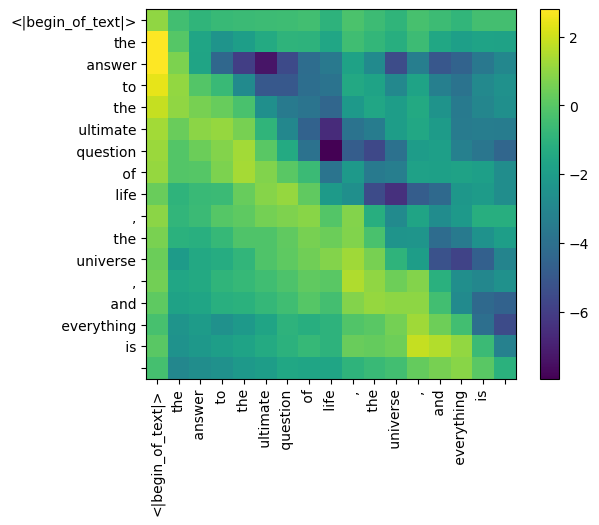

In [38]:
def display_qk_heatmap(qk_per_token):
    _, ax = plt.subplots()
    im = ax.imshow(qk_per_token.to(float).detach(), cmap='viridis')
    ax.set_xticks(range(len(prompt_split_as_tokens)))
    ax.set_yticks(range(len(prompt_split_as_tokens)))
    ax.set_xticklabels(prompt_split_as_tokens, rotation=90)
    ax.set_yticklabels(prompt_split_as_tokens)
    ax.figure.colorbar(im, ax=ax)
    
display_qk_heatmap(qk_per_token)

In [39]:
mask = torch.full((len(tokens), len(tokens)), float("-inf"), device=tokens.device)
mask = torch.triu(mask, diagonal=1)
mask

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -in

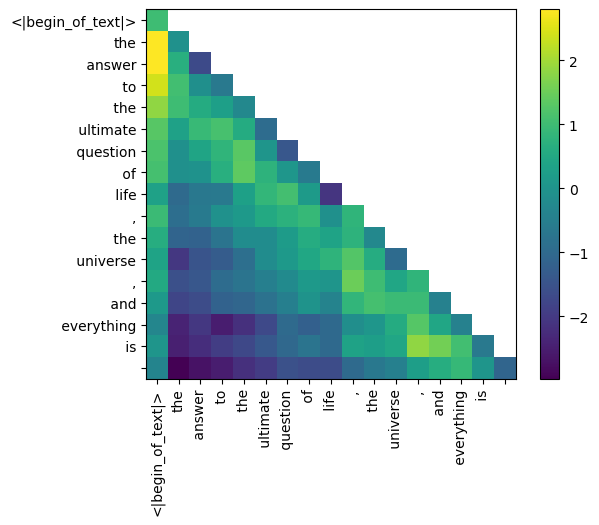

In [40]:
qk_per_token_after_masking = qk_per_token + mask
display_qk_heatmap(qk_per_token_after_masking)

<div>
    <img src="images/softmax.png" width="600px"/>
</div>

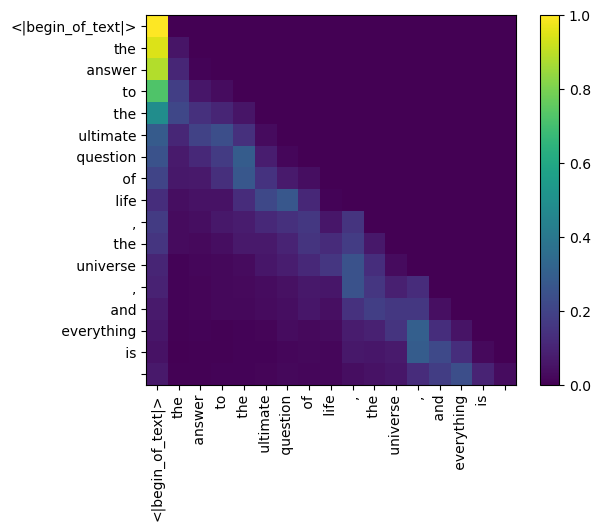

In [41]:
qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)
display_qk_heatmap(qk_per_token_after_masking_after_softmax)

<!-- ## values (almost the end of attention) -->
#### values (单头注意力的最后一部分)

<div>
    <img src="images/value.png" width="600px"/>
</div>
<!-- these scores (0-1) are used to determine how much of value matrix is used per token
<br>
&gt; just like keys, value weights are also shared acorss every 4 attention heads (to save computation)
<br>
&gt; as a result, the shape of the value weight matrix below is [8x128x4096] -->
这些得分 (0-1) 用于确定每个 token 使用多少 value 矩阵

就像 keys 一样, value weights 也在每 4 个注意力头之间共享 (以节省计算量)

因此, 下面的 value weight 矩阵的形状为 [8x128x4096]

In [42]:
print(
    model["layers.0.attention.wq.weight"].shape,
    model["layers.0.attention.wk.weight"].shape,
    model["layers.0.attention.wv.weight"].shape,
)

torch.Size([4096, 4096]) torch.Size([1024, 4096]) torch.Size([1024, 4096])


In [43]:
v_layer0 = model["layers.0.attention.wv.weight"]
v_layer0 = v_layer0.view(n_kv_heads, v_layer0.shape[0] // n_kv_heads, dim)
v_layer0.shape, v_layer0.dtype

(torch.Size([8, 128, 4096]), torch.bfloat16)

<!-- the first layer, first head value weight matrix is given below -->
第一层, 第一个头的 value weight 矩阵如下:

In [44]:
v_layer0_head0 = v_layer0[0]
v_layer0_head0.shape, v_layer0_head0.dtype

(torch.Size([128, 4096]), torch.bfloat16)

#### value vectors
<div>
    <img src="images/v0.png" width="600px"/>
</div>
<!-- we now use the value weghts to get the attention values per token, this is of size [17x128] where 17 is the number of tokens in the prompt and 128 is the dim of the value vector per token -->
我们现在使用 value weghts, 获取每个 token 的 attention 值, 其大小为 [17x128], 其中 17 是 prompt 中的 tokens 数量, 128 是每个 token 的 value vector 的长度

In [45]:
# 第一个头的 value
v_per_token = torch.matmul(token_embeddings, v_layer0_head0.T)
v_per_token.shape, v_per_token.dtype

(torch.Size([17, 128]), torch.bfloat16)

#### attention
<div>
    <img src="images/attention.png" width="600px"/>
</div>
<!-- the resultant attention vector after multipying with the values per token is of shape [17*128] -->
乘以每个 token 的 values 后, 得到的 attention 形状为 [17*128]

In [46]:
qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
qkv_attention.shape, qkv_attention.shape

(torch.Size([17, 128]), torch.Size([17, 128]))

### multi head attention
<div>
    <img src="images/heads.png" width="600px"/>
</div>
<!-- WE NOW HAVE THE ATTENTION VALUE OF THE FIRST LAYER AND FIRST HEAD
<br>
now im going to run a loop and perform the exact same math as the cells above but for every head in the first layer -->

我们现在得到第一层的第一个头的 attention 值

现在我们运行一个循环, 并执行与上面的单元格完全相同的数学运算, 但只用于**第一层中的每个头**

In [47]:
qkv_attention_store = []

for head in range(n_heads):
    q_layer0_head = q_layer0[head]
    k_layer0_head = k_layer0[head//4] # key weights are shared across 4 heads
    v_layer0_head = v_layer0[head//4] # value weights are shared across 4 heads
    q_per_token = torch.matmul(token_embeddings, q_layer0_head.T) # query of a head
    k_per_token = torch.matmul(token_embeddings, k_layer0_head.T) # key   of a head
    v_per_token = torch.matmul(token_embeddings, v_layer0_head.T) # value of a head

    # 通过旋转为 query 添加位置编码
    q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
    q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)
    q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers * freqs_cis[:len(tokens)])
    q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)

    # 通过旋转为 key 添加位置编码
    k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
    k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
    k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis[:len(tokens)])
    k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)

    # query * key / sqrt(d_k)
    qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(128)**0.5
    # softmax
    mask = torch.full((len(tokens), len(tokens)), float("-inf"), device=tokens.device)
    mask = torch.triu(mask, diagonal=1)
    qk_per_token_after_masking = qk_per_token + mask
    qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)
    
    qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
    qkv_attention_store.append(qkv_attention)

len(qkv_attention_store), qkv_attention_store[0].shape, qkv_attention_store[0].dtype

(32, torch.Size([17, 128]), torch.bfloat16)

<div>
    <img src="images/stacked.png" width="600px"/>
</div>
<!-- we now have a the qkv_attention matrix for all 32 heads on the first layer, next im going to merge all attention scores into one large matrix of size [17x4096]
<br>
we are almost at the end :) -->
我们现在得到第一层上所有 32 个头的 qkv_attention 矩阵, 接下来将所有 attention 合并到一个大小为 [17x4096] 的大矩阵中

In [48]:
stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)
stacked_qkv_attention.shape, stacked_qkv_attention.dtype

(torch.Size([17, 4096]), torch.bfloat16)

### weight matrix, one of the final steps
<div>
    <img src="images/weightmatrix.png" width="600px"/>
</div>
<!-- one of the last things to do for a layer 0 attention is, is to multiply the weight matrix of the  -->
第 1 层注意力要做的最后一件事是乘以权重矩阵

In [49]:
w_layer0 = model["layers.0.attention.wo.weight"]
w_layer0.shape

torch.Size([4096, 4096])

<!-- ### this is a simple linear layer, so we just matmul -->
#### 这是一个简单的线性层, 所以我们只需 matmul

In [50]:
embedding_delta = torch.matmul(stacked_qkv_attention, w_layer0.T)
embedding_delta.shape

torch.Size([17, 4096])

<div>
    <img src="images/afterattention.png" width="600px"/>
</div>
<!-- we now have the change in the embedding value after attention, that should be adding to the original token embeddings -->
在 attention 之后, embedding 值发生了变化, 它应该被添加到原始 token embeddings 中

In [51]:
embedding_after_edit = token_embeddings_unnormalized + embedding_delta
embedding_after_edit.shape

torch.Size([17, 4096])

其中, `token_embeddings_unnormalized`定义在[1.5节](#将tokens转换为embedding)

#### 我们进行归一化, 然后通过嵌入增量运行一个前馈神经网络
<div>
    <img src="images/norm_after.png" width="600px"/>
</div>

In [52]:
embedding_after_edit_normalized = rms_norm(embedding_after_edit, model["layers.0.ffn_norm.weight"])
print("embedding_after_edit | shape =", embedding_after_edit.shape, "dtype =", embedding_after_edit.dtype)
print("model['layers.0.ffn_norm.weight'] | shape =", model["layers.0.ffn_norm.weight"].shape, "dtype =", model["layers.0.ffn_norm.weight"].dtype)
print("embedding_after_edit_normalized | shape =", embedding_after_edit_normalized.shape, "dtype =", embedding_after_edit_normalized.dtype)

embedding_after_edit | shape = torch.Size([17, 4096]) dtype = torch.bfloat16
model['layers.0.ffn_norm.weight'] | shape = torch.Size([4096]) dtype = torch.bfloat16
embedding_after_edit_normalized | shape = torch.Size([17, 4096]) dtype = torch.bfloat16


其中, `rms_norm`定义在[1.6.1节](#使用-rms-归一化,-对嵌入进行归一化)

<!-- ## loading the ff weights and implementing the feed forward network -->
#### 加载 feed_forward 权重并实现前馈网络
<div>
    <img src="images/swiglu.png" width="600px"/>
</div>
<!-- in llama3, they used a SwiGLU feedforward network, this network architecture is really good at adding non linearity when needed by the model.
<br>
its pretty standard to use this feed forward network architecture in llms these days -->

在 llama3 中, 他们<font color="red">使用一个 **SwiGLU 前馈网络**, 这种网络架构非常**擅长在模型需要时添加非线性**</font>。

如今在 llms 中使用这种前馈网络架构是一种非常标准做法

In [53]:
w1 = model["layers.0.feed_forward.w1.weight"]
w2 = model["layers.0.feed_forward.w2.weight"]
w3 = model["layers.0.feed_forward.w3.weight"]
output_after_feedforward = torch.matmul(
    torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w3.T), w2.T
)
print("input (embedding_after_edit_normalized) | shape =", embedding_after_edit_normalized.shape)
print("output (output_after_feedforward) | shape =", output_after_feedforward.shape)

input (embedding_after_edit_normalized) | shape = torch.Size([17, 4096])
output (output_after_feedforward) | shape = torch.Size([17, 4096])


上述过程具体推导如下:

In [54]:
embedding_after_edit_normalized.shape, model["layers.0.feed_forward.w1.weight"].shape, model["layers.0.feed_forward.w3.weight"].shape

(torch.Size([17, 4096]), torch.Size([14336, 4096]), torch.Size([14336, 4096]))

In [55]:
torch.matmul(embedding_after_edit_normalized, w1.T).shape

torch.Size([17, 14336])

In [56]:
intermediate_var1 = torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T))
intermediate_var1.shape

torch.Size([17, 14336])

`torch.functional.F.silu`: **Si**gmoid **L**inear **U**nit 激活函数的数学表达式为:
$$\text{SiLU}(x) = x \cdot \sigma(x)$$
其中 $\sigma(x)$ 是 Sigmoid 函数 

In [57]:
intermediate_var2 = torch.matmul(embedding_after_edit_normalized, w3.T)
intermediate_var2.shape

torch.Size([17, 14336])

In [58]:
intermediate_var3 = intermediate_var1 * intermediate_var2
intermediate_var3.shape

torch.Size([17, 14336])

In [59]:
model["layers.0.feed_forward.w2.weight"].shape

torch.Size([4096, 14336])

In [60]:
torch.matmul(intermediate_var3, w2.T).shape

torch.Size([17, 4096])

<!-- # WE FINALLY HAVE NEW EDITED EMBEDDINGS FOR EACH TOKEN AFTER THE FIRST LAYER
just 31 more layers to go before we are done (one for loop away)
<br>
you can imagine this edited embedding as having information about all queries asked on the first layer
<br>
now each layer will encode more and more complex queries on the quesions asked, until we have an embedding that knows everything about the next token that we need. -->
### 在第一层最后, 对于每个 token 得到新编辑的 embeddings
只需再完成 31 层, 就可以完成 (只差一个循环)。

您可以<font color="red">将编辑过的 embedding 想象为包含(第一层上的所有查询的)信息</font>

现在, 每一层将针对所查询的问题编码越来越复杂的查询, 直到我们得到一个嵌入, 它知道我们需要的下一个词元的所有信息。

In [61]:
layer_0_embedding = embedding_after_edit + output_after_feedforward
layer_0_embedding.shape

torch.Size([17, 4096])

<!-- # god, everything all at once
<div>
    <img src="images/god.png" width="600px"/>
</div>
yep, this is it. everything we did before, all at once, for every single layer.
<br>

have fun reading :) -->

## 32层重复进行
<div>
 <img src="images/god.png" width="600px"/>
</div>

对于每个单层, 我们之前所做的一切都重复进行。

`token_embeddings_unnormalized`定义在[1.5节](#将tokens转换为embedding)

In [62]:
final_embedding = token_embeddings_unnormalized
for layer in range(n_layers):
    qkv_attention_store = []
    layer_embedding_norm = rms_norm(final_embedding, model[f"layers.{layer}.attention_norm.weight"])
    q_layer = model[f"layers.{layer}.attention.wq.weight"]
    q_layer = q_layer.view(n_heads, q_layer.shape[0] // n_heads, dim)
    k_layer = model[f"layers.{layer}.attention.wk.weight"]
    k_layer = k_layer.view(n_kv_heads, k_layer.shape[0] // n_kv_heads, dim)
    v_layer = model[f"layers.{layer}.attention.wv.weight"]
    v_layer = v_layer.view(n_kv_heads, v_layer.shape[0] // n_kv_heads, dim)
    w_layer = model[f"layers.{layer}.attention.wo.weight"]
    for head in range(n_heads):
        q_layer_head = q_layer[head]
        k_layer_head = k_layer[head//4]
        v_layer_head = v_layer[head//4]
        q_per_token = torch.matmul(layer_embedding_norm, q_layer_head.T)
        k_per_token = torch.matmul(layer_embedding_norm, k_layer_head.T)
        v_per_token = torch.matmul(layer_embedding_norm, v_layer_head.T)
        q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
        q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)
        q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers * freqs_cis)
        q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)
        k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
        k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
        k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis)
        k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)
        qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(128)**0.5
        mask = torch.full((len(token_embeddings_unnormalized), len(token_embeddings_unnormalized)), float("-inf"))
        mask = torch.triu(mask, diagonal=1)
        qk_per_token_after_masking = qk_per_token + mask
        qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)
        qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
        qkv_attention_store.append(qkv_attention)

    stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)
    w_layer = model[f"layers.{layer}.attention.wo.weight"]
    embedding_delta = torch.matmul(stacked_qkv_attention, w_layer.T)
    embedding_after_edit = final_embedding + embedding_delta
    embedding_after_edit_normalized = rms_norm(embedding_after_edit, model[f"layers.{layer}.ffn_norm.weight"])
    w1 = model[f"layers.{layer}.feed_forward.w1.weight"]
    w2 = model[f"layers.{layer}.feed_forward.w2.weight"]
    w3 = model[f"layers.{layer}.feed_forward.w3.weight"]
    output_after_feedforward = torch.matmul(torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w3.T), w2.T)
    final_embedding = embedding_after_edit + output_after_feedforward

In [63]:
final_embedding.shape, final_embedding.dtype

(torch.Size([17, 4096]), torch.bfloat16)

<!-- # we now have the final embedding, the best guess the model could make about the next token
the shape of the embedding is the same as regular token embeddings [17x4096] where 17 is the number of tokens and 4096 is the embedding dim -->
## 我们现在得到最终 embedding, 模型对下一个 token 做出的最佳猜测
embedding 的形状与常规 token embeddings 相同 [17x4096], 其中 17 是 tokens 的数量, 4096 是 embedding 的维度
    
<div>
    <img src="images/last_norm.png" width="600px"/>
</div>

In [64]:
final_embedding = rms_norm(final_embedding, model["norm.weight"])
final_embedding.shape

torch.Size([17, 4096])

<!-- # finally, lets decode the embedding into the token value
<div>
    <img src="images/finallayer.png" width="600px"/>
</div>
we will use the output decoder to convert the final embedding into a token -->

##  最后, 将 embedding 解码为 token 值
<div>
    <img src="images/finallayer.png" width="600px"/>
</div>
我们将使用输出解码器, 将最终 embedding 转换为一个 token

In [65]:
model["output.weight"].shape

torch.Size([128256, 4096])

<!-- # we use the embedding of the last token to predict the next value
hopefully in our case, 42 :)
note: 42 is the answer to "the answer to the ultimate question of life, the universe, and everything is ", according to the book "hitchhiker's guide to the galaxy", most mordern llms would answer with 42 here, which should validate our entire code! wish me luck :) -->
## 我们使用最后一个 token 的 embedding, 预测下一个值
在我们的例子中期望为 42

注意: 42 是"the answer to the ultimate question of life, the universe, and everything is"的回答, 根据《银河系漫游指南》一书, 大多数现代 llms 在这里都会回答 42, 这将验证我们的整个代码!

In [66]:
logits = torch.matmul(final_embedding[-1], model["output.weight"].T)
logits.shape

torch.Size([128256])

<!-- ### the model predicted token number 2983 as the next token, is this the token number for 42?
IM HYPING YOU UP, this is the last cell of code, hopefully you had fun :) -->
模型预测 token index 2983 为下一个 token, 这是 42 的 token index 吗?

In [67]:
next_token = torch.argmax(logits, dim=-1)
next_token

tensor(2983)

<div>
    <img src="images/42.png" width="600px"/>
</div>

In [68]:
tokenizer.decode([next_token.item()])

'42'

## what motivates me?

My friends and I are on a mission - to make research more accessible!
We created a research lab called A10 - [AAAAAAAAAA.org](http://aaaaaaaaaa.org/)

A10 twitter - https://twitter.com/aaaaaaaaaaorg

# Llama-3-8B 推理
- [X] https://huggingface.co/NousResearch/Meta-Llama-3-8B
- [ ] https://huggingface.co/NousResearch/Meta-Llama-3.1-8B

## 准备

In [ ]:
!conda install transformers=4.43.4 -c conda-forge
!conda install accelerate -c conda-forge

In [2]:
%cd /mnt/d/github
%cd llama3-from-scratch
!mkdir Nous-Llama-3-8B
%cd NousResearch-Llama-3-8B
!git clone https://huggingface.co/NousResearch/Meta-Llama-3-8B

/mnt/d/github
/mnt/d/github/llama3-from-scratch


## 推理方法1

In [ ]:
%cd /mnt/d/github
%cd llama3-from-scratch

In [3]:
import transformers
import torch

In [4]:
model_name_or_path = "./Nous-Llama-3-8B"

pipeline = transformers.pipeline(
    "text-generation", model=model_name_or_path, model_kwargs={"torch_dtype": torch.bfloat16}, device_map="auto"
)
output = pipeline("the answer to the ultimate question of life, the universe, and everything is ")

Loading checkpoint shards: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.30it/s]
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


In [12]:
print(output[0]["generated_text"])

the answer to the ultimate question of life, the universe, and everything is 42
42 is the answer to the ultimate question of life, the universe, and everything. It is also the number of the book of Revelation, the number of the beast, and the number of the beast. It is also the number of the beast, the number of the beast, and the number of the beast. It is also the number of the beast, the number of the beast, and the number of the beast. It is also the number of the beast, the number of the beast, and the number of the beast.
The number of the beast is the number of the beast. It is also the number of the beast, the number of the beast, and the number of the beast. It is also the number of the beast, the number of the beast, and the number of the beast. It is also the number of the beast, the number of the beast, and the number of the beast. It is also the number of the beast, the number of the beast, and the number of the beast.
The number of the beast is the number of the beast. It

## 推理方法2

In [1]:
%cd /mnt/d/github
%cd llama3-from-scratch

/mnt/d/github
/mnt/d/github/llama3-from-scratch


In [52]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name_or_path = "./Nous-Llama-3-8B"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [36]:
# 加载 tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)

In [39]:
# 加载模型
model = AutoModelForCausalLM.from_pretrained(model_name_or_path)

Loading checkpoint shards: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:37<00:00, 24.46s/it]


In [40]:
model.to(device)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
    (rotary_emb

In [41]:
# 本文输入
prompt = "the answer to the ultimate question of life, the universe, and everything is "
inputs = tokenizer(prompt, return_tensors="pt").to(device)

In [42]:
inputs

{'input_ids': tensor([[128000,   1820,   4320,    311,    279,  17139,   3488,    315,   2324,
             11,    279,  15861,     11,    323,   4395,    374,    220]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [43]:
model.device, inputs["input_ids"].device, inputs["input_ids"].dtype

(device(type='cpu'), device(type='cpu'), torch.int64)

In [ ]:
# 生成输出
outputs = model.generate(**inputs)

In [ ]:
# 解码输出
output_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(output_text)

## 模型结构可视化

In [44]:
from torchview import draw_graph

In [60]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
    (rotary_emb

### LlamaModel 可视化
[1.5](#将tokens转换为embedding) 到 [1.8](#我们现在得到最终-embedding,-模型对下一个-token-做出的最佳猜测) 的可视化

In [129]:
model.model

LlamaModel(
  (embed_tokens): Embedding(128256, 4096)
  (layers): ModuleList(
    (0-31): 32 x LlamaDecoderLayer(
      (self_attn): LlamaSdpaAttention(
        (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
        (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
        (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
        (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
        (rotary_emb): LlamaRotaryEmbedding()
      )
      (mlp): LlamaMLP(
        (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
        (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
        (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
        (act_fn): SiLU()
      )
      (input_layernorm): LlamaRMSNorm()
      (post_attention_layernorm): LlamaRMSNorm()
    )
  )
  (norm): LlamaRMSNorm()
  (rotary_emb): LlamaRotaryEmbedding()
)

In [127]:
model.model(inputs["input_ids"])["last_hidden_state"].shape

torch.Size([1, 17, 4096])

In [134]:
model_graph = draw_graph(
    model.model,
    input_data=inputs["input_ids"],
    graph_name="LlamaModel",
    depth=2,
    device=device,      # no memory is consumed for visualization
    expand_nested=True, # 显示带有虚线边框的嵌套模块
    save_graph=True,
)

### lm_head 可视化
[1.10](#我们使用最后一个-token-的-embedding,-预测下一个值) 的可视化

In [74]:
model.lm_head

Linear(in_features=4096, out_features=128256, bias=False)

In [135]:
model.lm_head(torch.randn(1, 17, 4096)).shape

torch.Size([1, 17, 128256])

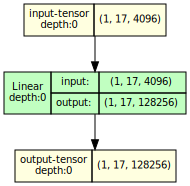

In [108]:
model_graph = draw_graph(
    model.lm_head,
    input_data=torch.randn(1, 17, 4096),
    graph_name="lm_head",
    depth=2,
    device=device,      # no memory is consumed for visualization
    expand_nested=True, # 显示带有虚线边框的嵌套模块
    save_graph=False,
)
model_graph.visual_graph

# to read
- https://www.linktont.com/2647